In [ ]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 610, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 610 (delta 137), reused 218 (delta 118), pack-reused 355 (from 1)
Receiving objects: 100% (610/610), 71.26 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (268/268), done.


In [ ]:
cd Tidal_try/

/content/Tidal_try


#Aberdeen

Selected start index for this run: 121958
Training set shape: (10000, 2)
Testing set shape: (2100, 2)
Training set X shape: (9900, 100, 1), Training set Y shape: (9900,)
Testing set X shape: (2000, 100, 1), Testing set Y shape: (2000,)
Training BiLSTM model...
Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.2175 - val_loss: 0.0746
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0625 - val_loss: 0.0445
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0402 - val_loss: 0.0354
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0324 - val_loss: 0.0300
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0275 - val_loss: 0.0259
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0237 - val_loss: 0.0226
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0205 - val_loss: 0.0198
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0178 - val_loss: 0.0174
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

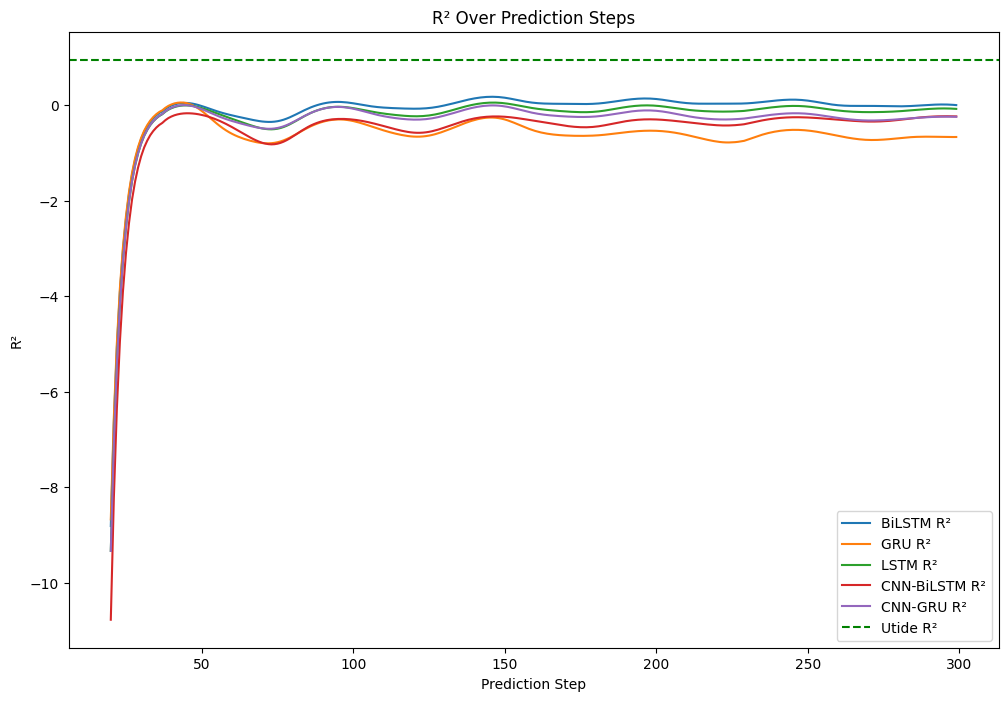

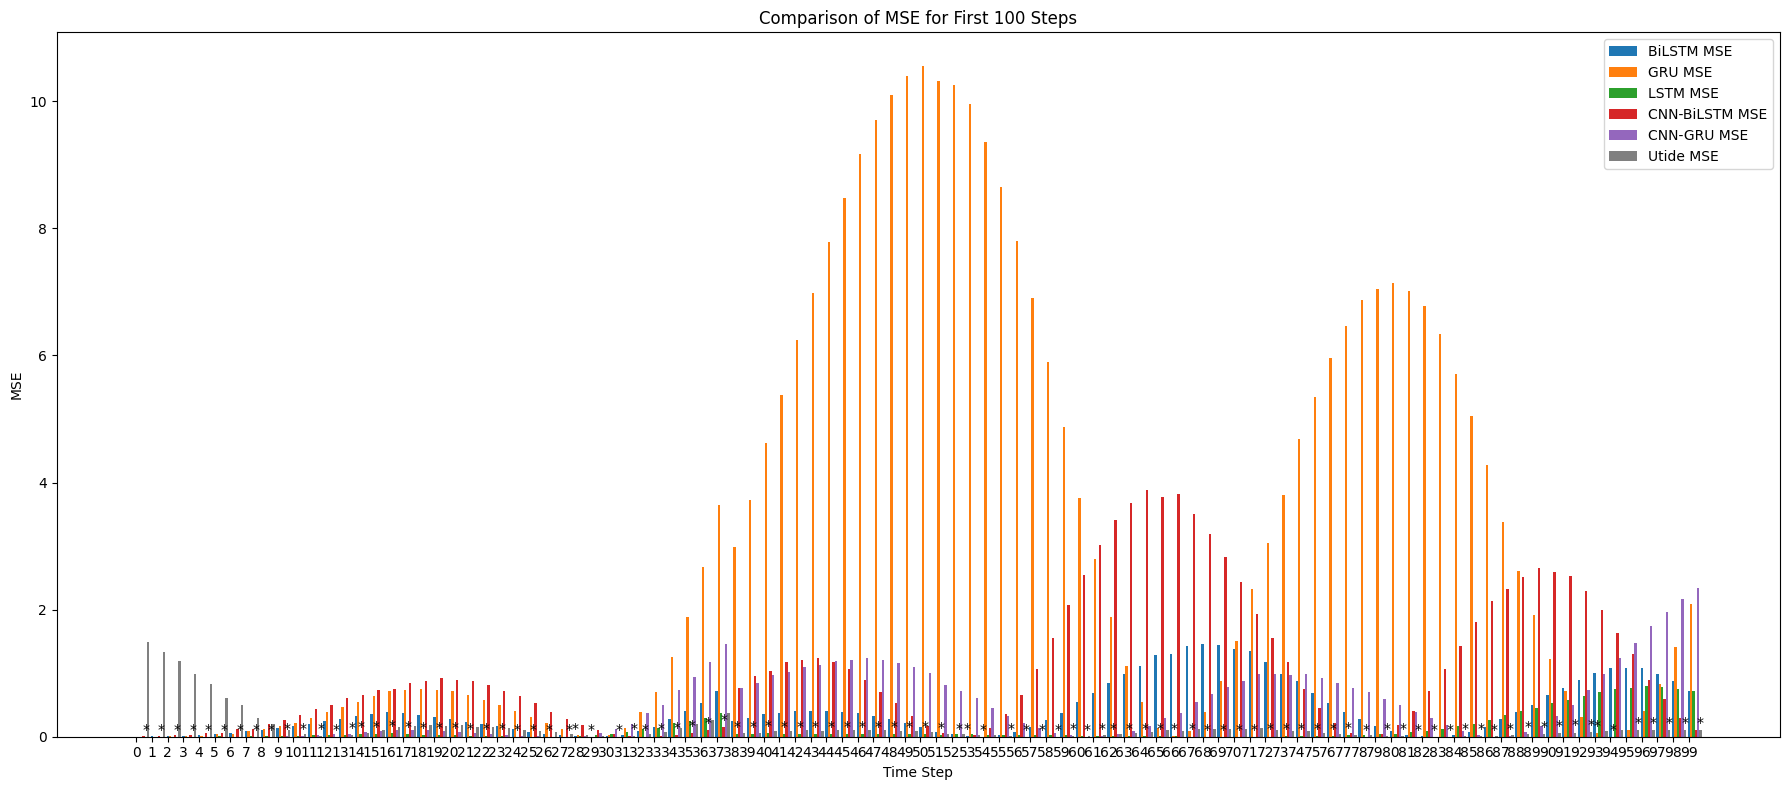

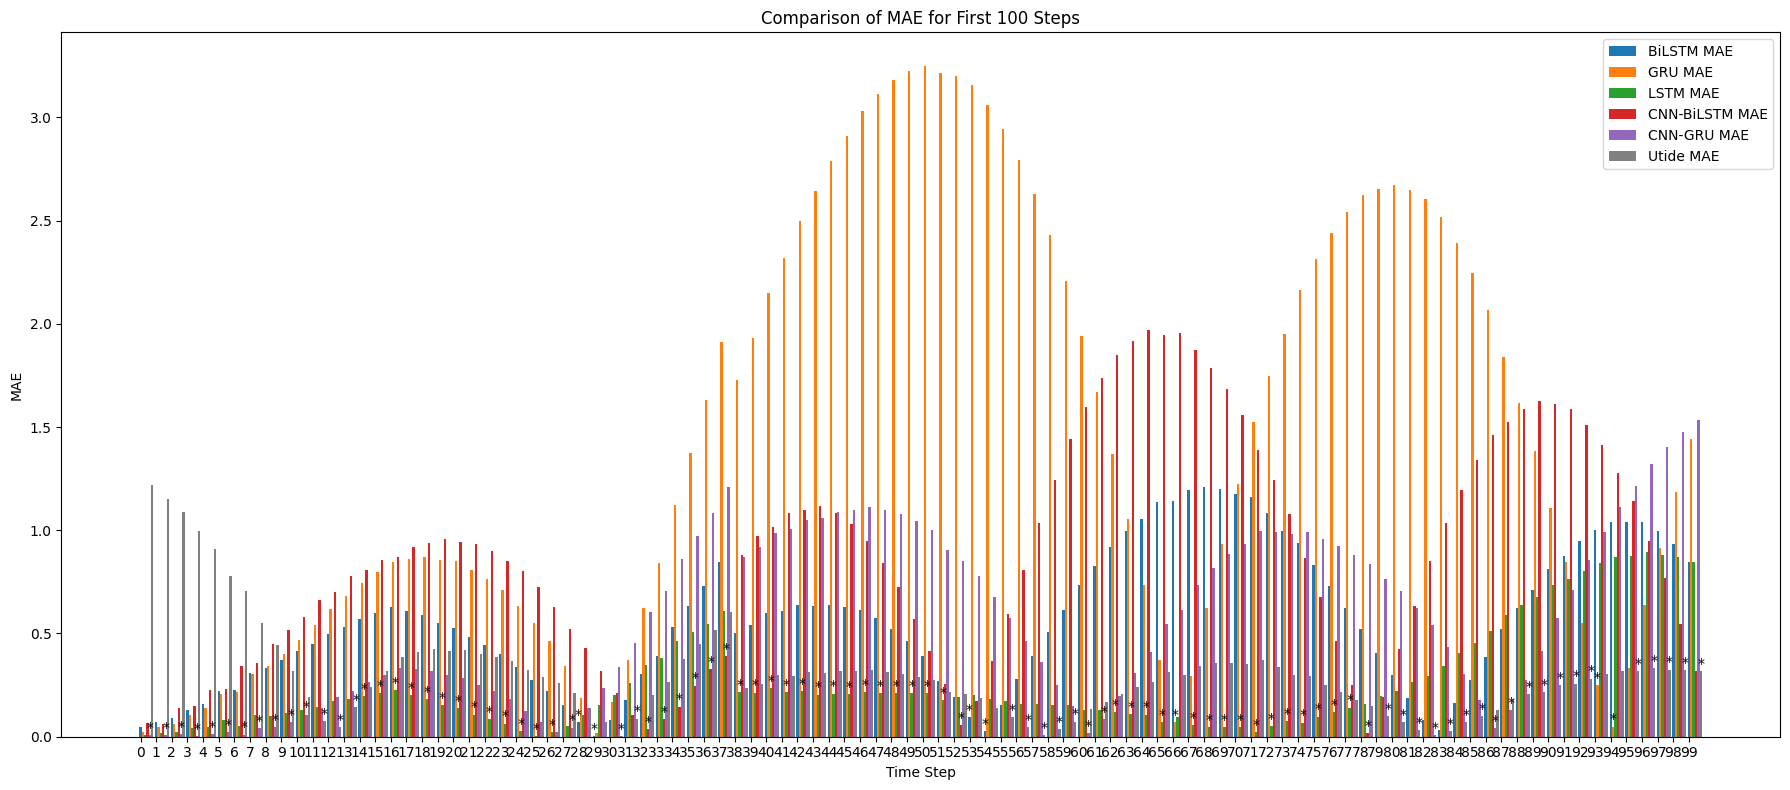

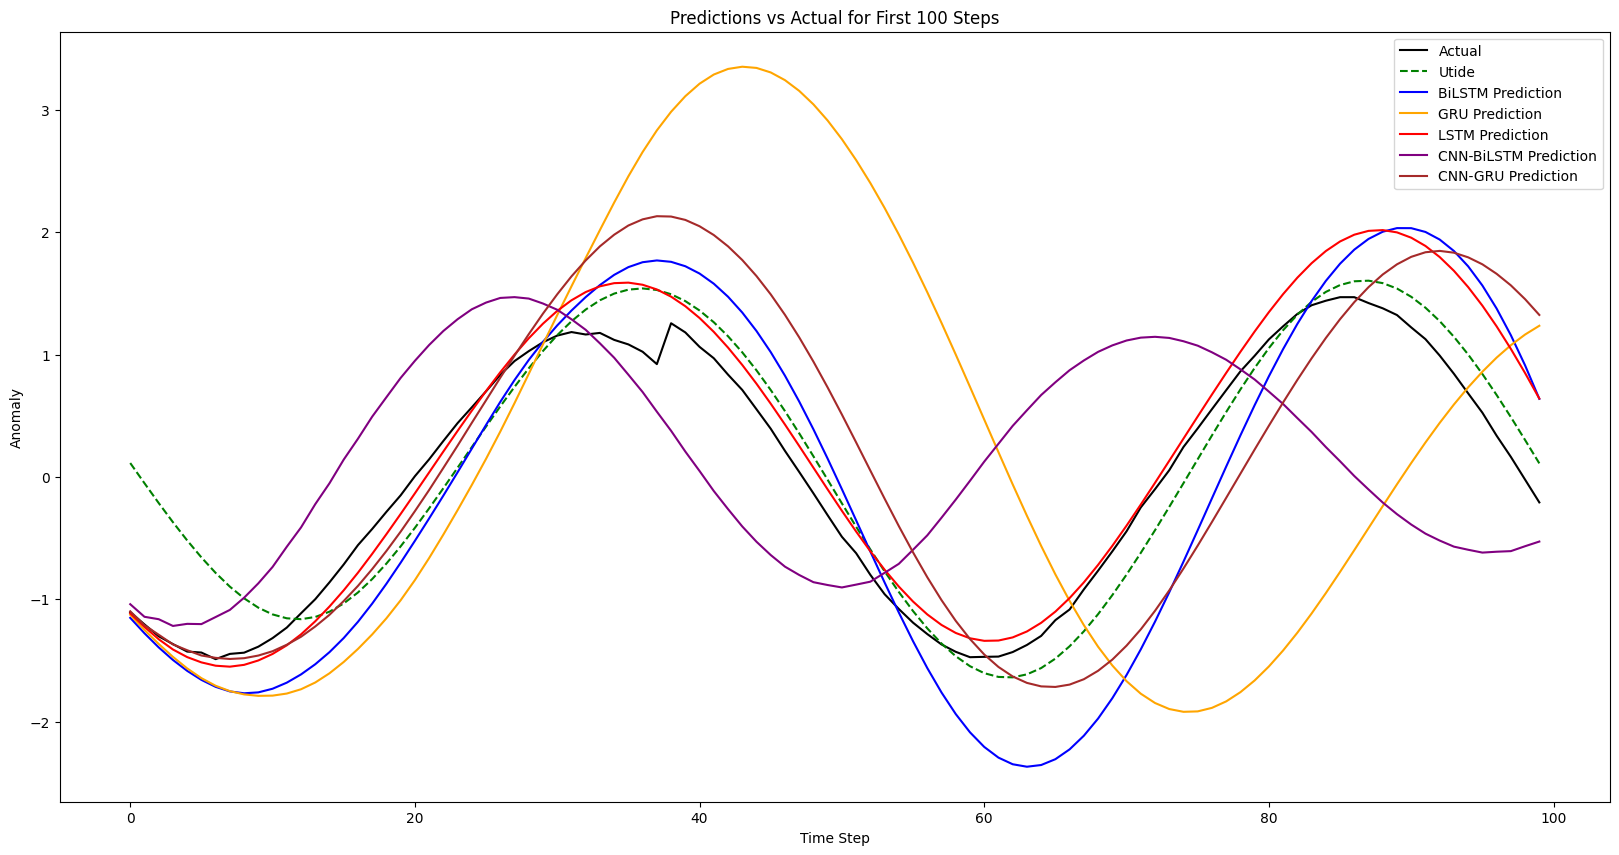

BiLSTM R² falls below Utide at step: 20
GRU R² falls below Utide at step: 20
LSTM R² falls below Utide at step: 20
CNN-BiLSTM R² falls below Utide at step: 20
CNN-GRU R² falls below Utide at step: 20


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, Input, Conv1D, MaxPooling1D, Flatten
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

df = pd.read_csv(input_file, delimiter=',')

total_train_points = 10000
look_back_points = 100
total_test_points = 2000

total_required = total_train_points + look_back_points + total_test_points

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index for this run: {start_index}")

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)

# Extract Features
anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide = df_sampled['utide'].values.reshape(-1, 1)

# Normalize Features
scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

# Combine Scaled Features
dataset_scaled = np.hstack((anomaly_scaled, utide_scaled))

# Split into Training and Testing Sets
train = dataset_scaled[:total_train_points]
test = dataset_scaled[total_train_points : total_train_points + total_test_points + look_back_points]

print(f"Training set shape: {train.shape}")
print(f"Testing set shape: {test.shape}")

# Create Dataset

def create_dataset(dataset, look_back, feature_indices):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), feature_indices]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


trainX, trainY = create_dataset(train, look_back=look_back_points, feature_indices=[0])
testX, testY = create_dataset(test, look_back=look_back_points, feature_indices=[0])

print(f"Training set X shape: {trainX.shape}, Training set Y shape: {trainY.shape}")
print(f"Testing set X shape: {testX.shape}, Testing set Y shape: {testY.shape}")


num_features = trainX.shape[2]


# BiLSTM
def build_bilstm(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(300, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(300, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

#  GRU
def build_gru(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(250, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(250, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# LSTM
def build_lstm(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(300, return_sequences=True, kernel_regularizer=l2(0.0001))(input_layer)
    x = Dropout(0.3)(x)
    x = LSTM(300, kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

#  CNN-BiLSTM
def build_cnn_bilstm(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2(0.0001)))(x)
    x = Bidirectional(LSTM(150, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# CNN-GRU
def build_cnn_gru(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(GRU(150, return_sequences=True, kernel_regularizer=l2(0.0001)))(x)
    x = Bidirectional(GRU(150, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# Initialize Models

models = {}
models['BiLSTM'] = build_bilstm((look_back_points, num_features))
models['GRU'] = build_gru((look_back_points, num_features))
models['LSTM'] = build_lstm((look_back_points, num_features))
models['CNN-BiLSTM'] = build_cnn_bilstm((look_back_points, num_features))
# Uncomment below to add CNN-GRU
models['CNN-GRU'] = build_cnn_gru((look_back_points, num_features))

# Train
for name, model in models.items():
    print(f"Training {name} model...")
    model.fit(trainX, trainY, validation_split=0.1, epochs=200, batch_size=256, verbose=1)
    print(f"{name} model training completed.\n")

#Rolling Prediction Function
def rolling_prediction(model, test, scaler_anomaly, scaler_utide, look_back):
    current_input = test[:look_back, 0].reshape(-1, 1)
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_test_points):
        input_sequence = current_input.reshape(1, look_back, 1)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly = prediction[0, 0]
        rolling_predictions.append(predicted_anomaly)

        actual_anomaly = test[look_back + i, 0]
        actual_inverse = scaler_anomaly.inverse_transform([[actual_anomaly]])[0, 0]
        utide_scaled = test[look_back + i, 1]
        utide_inverse = scaler_utide.inverse_transform([[utide_scaled]])[0, 0]
        predicted_inverse = scaler_anomaly.inverse_transform([[predicted_anomaly]])[0, 0]

        actual_values.append(actual_inverse)
        utide_values.append(utide_inverse)

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = predicted_anomaly

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

results = {}
for name, model in models.items():
    print(f"Performing rolling predictions with {name} model...")
    results[name] = rolling_prediction(model, test, scaler_anomaly, scaler_utide, look_back_points)
    print(f"Rolling predictions with {name} model completed.\n")

actual_values_full = scaler_anomaly.inverse_transform(test[look_back_points:look_back_points + total_test_points, 0].reshape(-1,1)).flatten()
utide_values_full = scaler_utide.inverse_transform(test[look_back_points:look_back_points + total_test_points, 1].reshape(-1,1)).flatten()

# Compute R² for Utide
r2_utide = r2_score(actual_values_full, utide_values_full)


start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

plt.figure(figsize=(12, 8))
for name in models.keys():
    plt.plot(indices, results[name]['r2_scores'][indices], label=f'{name} R²')
plt.axhline(y=r2_utide, color='green', linestyle='--', label='Utide R²')
plt.xlabel('Prediction Step')
plt.ylabel('R²')
plt.title('R² Over Prediction Steps')
plt.legend()
plt.show()

#mse mae
steps_to_plot = 100  # Adjust as needed
x = np.arange(steps_to_plot)
width = 0.15  # Adjust based on number of models

# Initialize MSE and MAE dictionaries
mse_dict = {}
mae_dict = {}

# Compute MSE and MAE for each model
for name in models.keys():
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = scaler_anomaly.inverse_transform(results[name]['predicted_values'][:steps_to_plot].reshape(-1,1)).flatten()
    mse = (actual - predicted) ** 2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

# Compute MSE and MAE for Utide
utide_predicted = utide_values_full[:steps_to_plot]
mse_utide = (actual_values_full[:steps_to_plot] - utide_predicted) ** 2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_predicted)

# Plot MSE
plt.figure(figsize=(18, 8))
for idx, (name, mse) in enumerate(mse_dict.items()):
    plt.bar(x + idx * width, mse, width, label=f'{name} MSE')
plt.bar(x + len(mse_dict) * width, mse_utide, width, label='Utide MSE', color='grey')

# Mark the minimum error per step
for i in range(steps_to_plot):
    errors = [mse_dict[name][i] for name in models.keys()] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    plt.text(i + min_idx * width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.xlabel('Time Step')
plt.ylabel('MSE')
plt.title(f'Comparison of MSE for First {steps_to_plot} Steps')
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(18, 8))
for idx, (name, mae) in enumerate(mae_dict.items()):
    plt.bar(x + idx * width, mae, width, label=f'{name} MAE')
plt.bar(x + len(mae_dict) * width, mae_utide, width, label='Utide MAE', color='grey')

# Mark the minimum error per step
for i in range(steps_to_plot):
    errors = [mae_dict[name][i] for name in models.keys()] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    plt.text(i + min_idx * width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.xlabel('Time Step')
plt.ylabel('MAE')
plt.title(f'Comparison of MAE for First {steps_to_plot} Steps')
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))

# Plot actual
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')

# Plot Utide
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

# Plot predictions
colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(models.keys()):
    predicted = scaler_anomaly.inverse_transform(results[name]['predicted_values'][:steps_to_plot].reshape(-1,1)).flatten()
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title(f'Predictions vs Actual for First {steps_to_plot} Steps')
plt.legend()
plt.show()


for name in models.keys():
    model_r2 = results[name]['r2_scores'][indices]

    utide_r2_constant = r2_utide
    falloff_indices = np.where(model_r2 < utide_r2_constant)[0]
    first_falloff = falloff_indices[0] + start_index_plot if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")

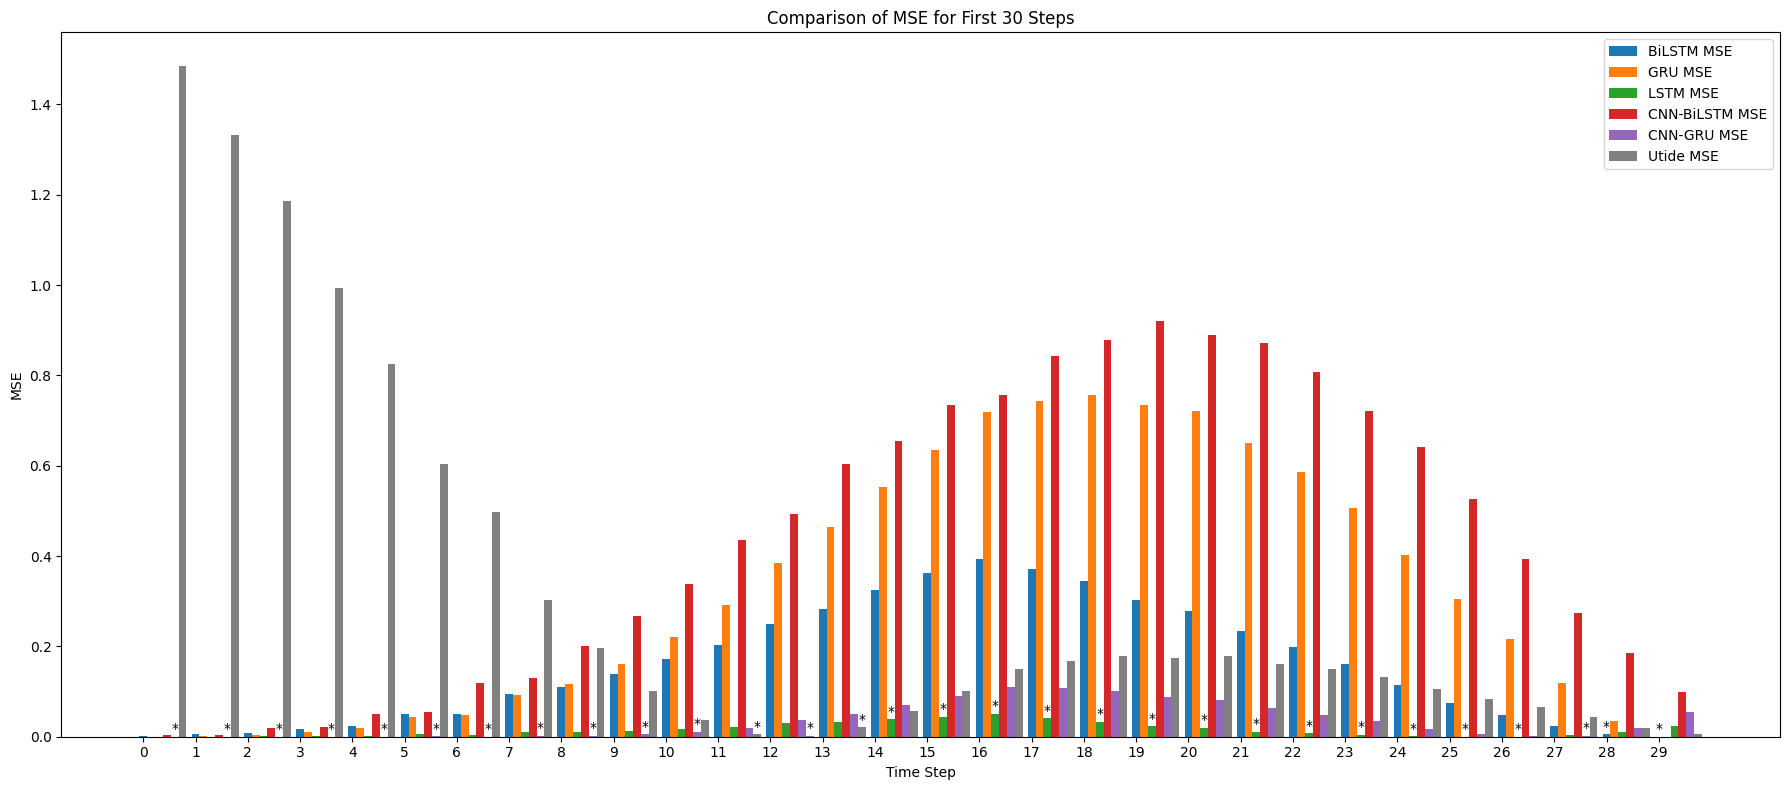

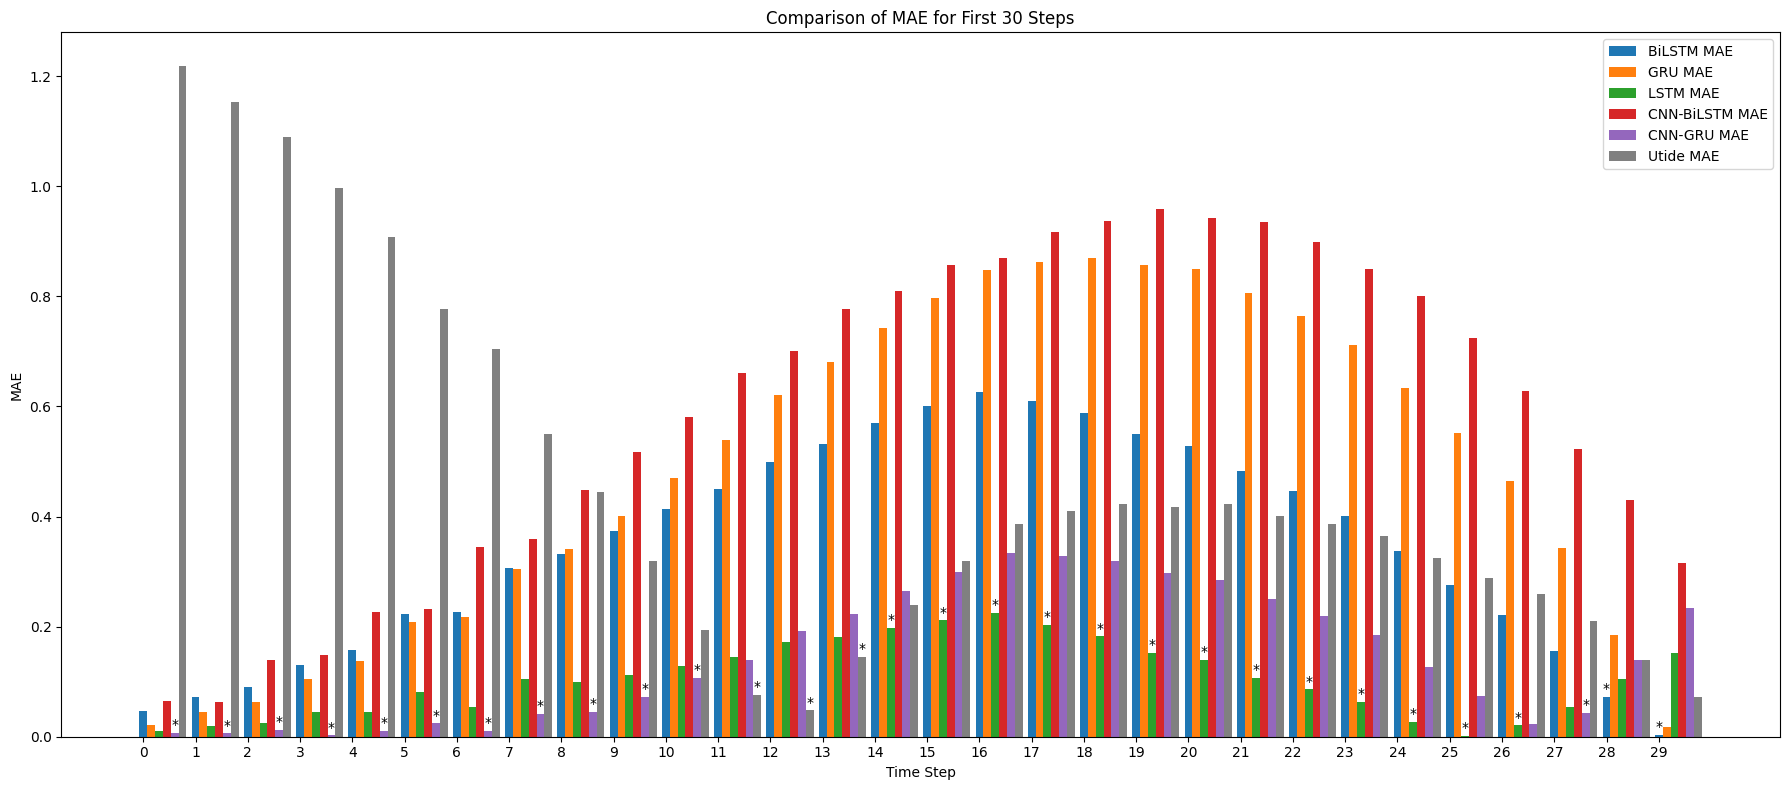

In [ ]:
steps_to_plot = 30  # Adjust as needed
x = np.arange(steps_to_plot)
width = 0.15  # Adjust based on number of models

# Initialize MSE and MAE dictionaries
mse_dict = {}
mae_dict = {}

# Compute MSE and MAE for each model
for name in models.keys():
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = scaler_anomaly.inverse_transform(results[name]['predicted_values'][:steps_to_plot].reshape(-1,1)).flatten()
    mse = (actual - predicted) ** 2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

# Compute MSE and MAE for Utide
utide_predicted = utide_values_full[:steps_to_plot]
mse_utide = (actual_values_full[:steps_to_plot] - utide_predicted) ** 2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_predicted)

# Plot MSE
plt.figure(figsize=(18, 8))
for idx, (name, mse) in enumerate(mse_dict.items()):
    plt.bar(x + idx * width, mse, width, label=f'{name} MSE')
plt.bar(x + len(mse_dict) * width, mse_utide, width, label='Utide MSE', color='grey')

# Mark the minimum error per step
for i in range(steps_to_plot):
    errors = [mse_dict[name][i] for name in models.keys()] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    plt.text(i + min_idx * width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.xlabel('Time Step')
plt.ylabel('MSE')
plt.title(f'Comparison of MSE for First {steps_to_plot} Steps')
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(18, 8))
for idx, (name, mae) in enumerate(mae_dict.items()):
    plt.bar(x + idx * width, mae, width, label=f'{name} MAE')
plt.bar(x + len(mae_dict) * width, mae_utide, width, label='Utide MAE', color='grey')

# Mark the minimum error per step
for i in range(steps_to_plot):
    errors = [mae_dict[name][i] for name in models.keys()] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    plt.text(i + min_idx * width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.xlabel('Time Step')
plt.ylabel('MAE')
plt.title(f'Comparison of MAE for First {steps_to_plot} Steps')
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()


#